# Dataset

**EMBER** Dataset: Περιέχει εξαγμένα δεδομένα απο στατική ανάλυση 1.1 εκατομμυρίων samples binary αρχείων για Windows(PE files).
<br>Συγκεκριμένα περιέχει 2 datasets:
1. Training File **900K samples** με 300K malicious, 300K benign, 300K unlabeled
2. Test File **200K samples** με 100K malicious, 100K benign

https://arxiv.org/pdf/1804.04637.pdf

Τα δεδομένα βρίσκονται σε 7 jsonl αρχεία συνολικού μεγέθους 9.8GB, περιέχουν raw δεδομένα τα οποία χρειάζονται προετοιμασία (vectorization) πριν να μπορέσουν να χρησιμοποιηθούν για model training.<br>
Παρέχεται όμως συμπληρωματικός κώδικας που κάνει vectorization καθώς και κώδικας για κατασκευή μοντέλων.

# Pre-Processing

Ακολούθησα την παρακάτω διαδικασία:
- **Script για επεξεργασία των training jsonl αρχείων ώς εξής:**
  1. Διαγραφή των unlabeled δεδομένων
  2. Shuffle των δεδομένων ώστε να υπάρχει κάποιο balance σε malware και benign δεδομένων
  3. Εξαγωγή συγκεκριμένου αριθμού δεδομένων, για να μπορώ να κάνω testing σε μικρό όγκο δεδομένων
 <br><br>
- **Αντίστοιχο script για επεξεργασία των testing jsonl αρχείων**
<br><br>
- **Αλλαγή του κώδικα του library που παρέχεται για το vectorization**
<br>Το function του vectorization που παρέχεται έχει πολύ standardized process και άρα η αλλαγή του κώδικα είναι απαραίτητη για να δουλεύει για τα custom αρχεία που φτιάχω παραπάνω.
<br>Παρακάτω φαίνεται η διαδικασία εισαγωγής των δεδομένων που παράχθηκαν παραπάνω για model training:
  

In [1]:
## IMPORTS
import numpy as np
import pandas as pd
import os
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import graphviz

In [2]:
## DATA IMPORTS
train_size = 100000
test_size = 40000
columns = 2351

path = "./data"

x_train = np.memmap(path+"/X_train.dat", dtype=np.float32, mode="r", shape=(train_size, 2351))
y_train = np.memmap(path+"/y_train.dat", dtype=np.float32, mode="r", shape=train_size)

x_validation = x_train[70000:90000]
y_validation = y_train[70000:90000]

x_train = x_train[:40000]
y_train = y_train[:40000]

x_test = np.memmap(path+"/X_test.dat", dtype=np.float32, mode="r", shape=(test_size, 2351))
y_test = np.memmap(path+"/y_test.dat", dtype=np.float32, mode="r", shape=test_size)

# Δεδομένα

Έχω φτιάξει 2 αρχεια, 1 για training και 1 για testing.
<br>
Για training χρησιμοποιώ 40Κ samples και για testing επίσης 40Κ samples.
<br>
Για να αποφύγω το overfitting χρησιμοποιώ ένα ανεξάρτητο μέρος του training set για validation set με μέγεθος 20Κ samples.
<br>
Το κάθε sample(row) αποτελείται απο 2351 features(columns):
- ByteHistogram (256 columns, Byte histogram (count + non-normalized) over the entire binary file)
- ByteEntropyHistogram (256 columns, byte/entropy histogram, This roughly approximates the joint probability of byte value and local entropy.)
- SectionInfo (255 columns, Information about section names, sizes and entropy.)
- ImportsInfo (1280 columns, Information about imported libraries and functions from the import address table.)
- ExportsInfo (128 columns, Information about exported functions)
- GeneralFileInfo (10 columns, General information about the file)
- HeaderFileInfo (62 columns, Machine, architecure, OS, linker and other information)
- StringExtractor (104 columns, Extracted strings from raw byte stream)


In [6]:
print(f"Training set size: {len(y_train)}, Validation set size: {len(y_validation)}, Test set size: {len(y_test)}.")

Training set size: 40000, Validation set size: 20000, Test set size: 40000.


# Model Training - Decision Tree Classifier

Επέλεξα να δοκιμάσω να κάνω train ένα **decision tree** σαν εισαγωγή για να χρησιμοποιήσω τα αποτελέσματα σαν benchmark για πίο περίπλοκους αλγόριθμους που βασίζονται σε πολλαπλά δέντρα αποφάσεων.
<br>
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
<br>
https://scikit-learn.org/stable/modules/tree.html

In [9]:
model = tree.DecisionTreeClassifier()
%time model.fit(x_train, y_train)
print(f" Accuracy on validation set: {model.score(x_validation, y_validation)}")

CPU times: user 2min 20s, sys: 72 ms, total: 2min 21s
Wall time: 2min 21s
 Accuracy on validation set: 0.96055


# Parameter Optimization
Τεστάρω διαφορετικές τιμές για τις παραμέτρους του αλγορίθμου για βελτιστοποίηση. 
<br>Η βελτιστοποίηση αποτελέιται απο:
- Καλύτερο **accuracy** (στο validation set και τελικά στο test set).
- Μικρότερο **running time** του αλγορίθμου.

Οι παράμετροι που τεστάρω είναι οι ακόλουθες:
1. max_depths, Περιορίζει πόσο βαθύ μπορεί να είναι το δέντρο. 
   - Μικρές τιμές οδηγούν:
       - Mικρότερο running time
       - Χειρότερο accuracy
   - Μεγάλες τιμές οδηγούν:
        - Μεγαλύτερο running time
        - Καλύτερο accuracy
        - Πιθανότητα ωστόσο για overfitting στα training data.

CPU times: user 3.47 s, sys: 4 µs, total: 3.47 s
Wall time: 3.47 s
CPU times: user 6.84 s, sys: 0 ns, total: 6.84 s
Wall time: 6.84 s
CPU times: user 17.5 s, sys: 0 ns, total: 17.5 s
Wall time: 17.5 s
CPU times: user 31.5 s, sys: 0 ns, total: 31.5 s
Wall time: 31.5 s
CPU times: user 55 s, sys: 0 ns, total: 55 s
Wall time: 55 s
CPU times: user 1min 45s, sys: 3.96 ms, total: 1min 45s
Wall time: 1min 45s
CPU times: user 2min 18s, sys: 0 ns, total: 2min 18s
Wall time: 2min 18s
CPU times: user 2min 32s, sys: 0 ns, total: 2min 32s
Wall time: 2min 32s
CPU times: user 2min 19s, sys: 0 ns, total: 2min 19s
Wall time: 2min 19s
CPU times: user 2min 15s, sys: 0 ns, total: 2min 15s
Wall time: 2min 15s
CPU times: user 2min 17s, sys: 136 ms, total: 2min 17s
Wall time: 2min 17s
CPU times: user 2min 30s, sys: 200 ms, total: 2min 30s
Wall time: 2min 30s


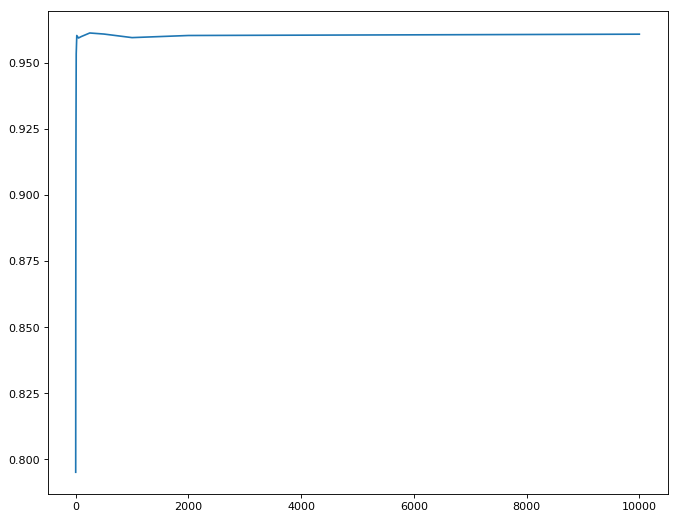

In [10]:
max_depths = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000, 2000, 10000]
scores = []
for depth in max_depths:
    model = tree.DecisionTreeClassifier(max_depth=depth)
    %time model.fit(x_train, y_train)
    scores.append(model.score(x_validation, y_validation))
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(max_depths, scores)